## Βασιλειάδης Μιλτιάδης 2944
Ερώτηση 2

In [2]:
import numpy as np
import scipy.sparse as sp_sparse

import pandas as pd

import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import string as string
import sklearn.feature_extraction.text as sk_text
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import json
%matplotlib inline
import sklearn.utils as utils
from sklearn.model_selection import train_test_split

import datetime as dt

import gensim

In [3]:
skipgram_model = None
strings_skipgram = []
window_sizes = [10,50,100,1000]
kappas = [1,5,10,20,40,50,60,70,80,100]
business={}
reviews=[]
estimations=[]
#ICF_estimations=[]
business_similarities=[]
dtype = pd.SparseDtype(float)
compression_opts = dict(method='zip',
                            archive_name='out.csv')

Let's load the JSONs and prune them, reading line by line. First businesses in Toronto and with at least 15 Reviews

In [4]:
def prune():
    global business,reviews
    with open('yelp_academic_dataset_business.json',mode='r',encoding='utf-8',errors='ignore') as fbusiness:
        for jsonline in fbusiness:
            read = json.loads(jsonline)
            if read["city"] == "Toronto" and read["review_count"] >= 15  :
                business[read["business_id"]] = ''
                #business.append(read["business_id"])

    with open('yelp_academic_dataset_review.json',mode='r',encoding='utf-8',errors='ignore') as freviews:
        for jsonline in freviews:
            read = json.loads(jsonline)
            if read['business_id'] in business:
                dct = {
                'user_id':read['user_id'],
                'business_id':read['business_id'],
                'date':dt.datetime.strptime(read['date'],"%Y-%m-%d %H:%M:%S"),
                'rating':read['stars']
                }
                reviews.append(dct)

    reviews=pd.DataFrame(reviews)

The function below writes the pruned data to a csv file.  I did that to save time when testing uncomment uncomment prune() and comment reviews=pd.read_csv('prunedex2.zip',compression=compression_opts) do read the original files

In [5]:
def save():
    global reviews
    global compression_opts
    reviews.to_csv('prunedex2.zip',index=False,compression=compression_opts)

In [6]:
#prune()
#save()

In [7]:
reviews=pd.read_csv('prunedex2.zip',compression=compression_opts)

This counts and ensures that businesses have at least 15 reviews from and to each other. Two times each.

In [8]:
reviews['freq'] = reviews.groupby('user_id')['user_id'].transform('count')
reviews.drop(reviews.index[reviews['freq'] < 15], inplace = True)
reviews['freq'] = reviews.groupby('business_id')['business_id'].transform('count')
reviews.drop(reviews.index[reviews['freq'] < 15], inplace = True)
reviews['freq'] = reviews.groupby('user_id')['user_id'].transform('count')
reviews.drop(reviews.index[reviews['freq'] < 15], inplace = True)
#reviews['freq'] = reviews.groupby('business_id')['business_id'].transform('count')
#reviews.drop(reviews.index[reviews['freq'] < 15], inplace = True)
reviews.drop(columns='freq',inplace=True)

In [9]:
reviews.reset_index(inplace=True,drop=True)
reviews.head()

,user_id,business_id,date,rating
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,2017-06-06 19:04:10,4.0
1,AdMCAKmNDIaubYPxnjTq1g,nIIuxIn5RU0j-XkDWh3hlA,2018-10-04 14:12:57,1.0
2,1kNsEAhGU8d8xugMuXJGFA,cDoo0Pf1d_P79Rq3ZNk-Mw,2013-07-13 00:57:45,3.0
3,Kl6jNDAE7PG_VVQafIptxQ,IfUkm42SB9D0m_ZbkQ711A,2013-04-10 17:43:11,4.0
4,is1nHZ4oBqqmBm_mfVyhoQ,NrJSy3dgcXErFtOKGREmnw,2017-09-08 23:06:29,4.0


In [10]:
X_train, X_test= train_test_split(reviews, 
#test_size=0.01,
test_size=100,
random_state=2944)
X_train = X_train.sort_values('date')

In [11]:
del reviews

This groups by each business and each user all the users/businesses that have been reviewed by and have given reviews to respectively

In [12]:
bgrp = X_train.groupby(by='business_id',sort=True)
groups = dict(list(bgrp))
business_users = []
for bid in groups.keys():
    text = ''
    text =''.join(groups[bid]['user_id'].tolist())
    business_users.append({bid:text})


ugrp = X_train.groupby(by='user_id',sort=True)
groups = dict(list(ugrp))
users_business = []
for uid in groups.keys():
    text = ''
    text =''.join(groups[uid]['business_id'].tolist())
    users_business.append({uid:text})

In [13]:
def embedder(strings,w):   
    import gensim 
    from gensim.models import Word2Vec
    global skipgram_model
    embedding_size = 100
    skipgram_model = gensim.models.Word2Vec(strings,min_count = 1,size = embedding_size, window = w, sg = 1,workers=8) 

    global strings_skipgram
    strings_skipgram = []
    for x in strings:
        vx = np.zeros(embedding_size)
        for w in x: 
            vx += skipgram_model.wv[w]
        vx /= len(x)
        strings_skipgram.append(vx)
#embedder(users_business,15)

Make sparse dataframes of the ratings user/business(for UCF) and business/users (for ICF). For some reason transposing X_train threw an error

In [14]:
X_train_business_first = X_train.pivot_table(index='business_id',columns='user_id',values='rating')
X_train_business_first =X_train_business_first.astype(dtype)
X_train = X_train.pivot_table(index='user_id',columns='business_id',values='rating')
X_train=X_train.astype(dtype)

In [15]:
X_test = X_test.to_dict('records')

UCF takes for each user and business the other users that have rated this business finds the similarities between the user and those other users and calculates an estimation based on the similarity and the rating divided by the sum of all similarities

In [16]:
def UCF(k):
    global X_train
    global X_test
    global user_similarities
    global estimations
    for record in X_test:
        uid=record['user_id']
        bid=record['business_id']
        same_businesses = X_train[bid].dropna().index
        similarity_vector = user_similarities.loc[uid][same_businesses]
        #print(similarity_vector.array)
        top_similar_indexes=similarity_vector.argsort()[-k:]
        top_similar=similarity_vector.array[top_similar_indexes]
        #print(top_similar)
        #print(top_similar_indexes.index)
        similar_ratings = X_train.loc[top_similar_indexes.index][bid].array
        #print(similar_ratings)
        estimation = {'user_id':uid,'business_id':bid,'k':k,'w':w,'rating':sum(similar_ratings*top_similar)/sum(top_similar),'method':'UCF'}
        #print(estimation)
        estimations.append(estimation)

In [17]:
for w in window_sizes:
    embedder(users_business,w)
    user_similarities = pd.DataFrame(data=cosine_similarity(strings_skipgram),index=X_train.index,columns=X_train.index)
    for k in kappas:
        UCF(k)

ICF takes for each business and each user the other businesses that have been rated by the same user computes the similarities and the rating is computed as similarity(i)*rating(i)/sum of all similarities

In [18]:
def ICF(k,data):
    global X_test
    global business_similarities
    global estimations
    X_train=data
    for record in X_test:
        uid=record['user_id']
        bid=record['business_id']
        same_users = X_train[uid].dropna().index
        similarity_vector = business_similarities.loc[bid][same_users]
        top_similar_indexes=similarity_vector.argsort()[-k:]
        top_similar=similarity_vector.array[top_similar_indexes]
        similar_ratings = X_train.loc[top_similar_indexes.index][uid].array
        estimation = {'user_id':uid,'business_id':bid,'k':k,'w':w,'rating':sum(similar_ratings*top_similar)/sum(top_similar),'method':'ICF'}
        #print(estimation)
        estimations.append(estimation)

In [19]:
for w in window_sizes:
    embedder(business_users,w)
    business_similarities = pd.DataFrame(data=cosine_similarity(strings_skipgram),index=X_train_business_first.index,columns=X_train_business_first.index)
    for k in kappas:
        ICF(k,X_train_business_first)

In [20]:
user_similarities= pd.DataFrame(data = cosine_similarity(X_train.to_numpy(na_value=0),dense_output=True),index=X_train.index,columns=X_train.index)
w=0
for k in kappas:
    UCF(k)

In [21]:
business_similarities = pd.DataFrame(data = cosine_similarity(X_train_business_first.to_numpy(na_value=0),dense_output=True),index=X_train_business_first.index,columns=X_train_business_first.index)
w=0
for k in kappas:
    ICF(k,X_train_business_first)

In [22]:
del X_train,X_train_business_first,user_similarities,business_similarities

In [23]:
df = pd.DataFrame(data=estimations)
dfTest = pd.DataFrame(data=X_test)
dfTest.drop(columns=['date'],inplace=True)

In [24]:
display(df.head(),dfTest.head())

,user_id,business_id,k,w,rating,method
0,ogGW1hddNjqY3LrldLBr4g,yHCoJZh5nx0Onr5xgMaUHg,1,10,2.666667,UCF
1,fxEoLJp5wTyw2sc5dmktrA,dAmVTQ6ukuLh4UxTmBoRkg,1,10,4.000000,UCF
2,XrYTMhY9YJvzX2pMepIz7A,JImufwPgbxHdGzoxKE5Ijw,1,10,5.000000,UCF
3,JrXC_MDp38BWwLn2SFdNsA,WmuoWetYC-4U2-V4taC6Wg,1,10,5.000000,UCF
4,gjhzKWsqCIrpEd9pevbKZw,JsAjP49bCk9KjJmmmjyM4w,1,10,4.000000,UCF


,user_id,business_id,rating
0,ogGW1hddNjqY3LrldLBr4g,yHCoJZh5nx0Onr5xgMaUHg,4.0
1,fxEoLJp5wTyw2sc5dmktrA,dAmVTQ6ukuLh4UxTmBoRkg,4.0
2,XrYTMhY9YJvzX2pMepIz7A,JImufwPgbxHdGzoxKE5Ijw,4.0
3,JrXC_MDp38BWwLn2SFdNsA,WmuoWetYC-4U2-V4taC6Wg,3.0
4,gjhzKWsqCIrpEd9pevbKZw,JsAjP49bCk9KjJmmmjyM4w,3.0


In [25]:
from sklearn.metrics import mean_squared_error
import math
y_actual = dfTest.rating
methods=['UCF','ICF']
rmses=[]
window_sizes = [0,10,50,100,1000]
for m in methods:
    for w in window_sizes:
        for k in kappas:
            y_predicted = df.loc[(df['method']==m) & (df['k']==k) & (df['w']==w)].rating
            MSE = mean_squared_error(y_actual, y_predicted)
            RMSE = math.sqrt(MSE)
            rmses.append({'method':m,'k':k,'w':w,'RMSE':RMSE})



In [26]:
rmses = pd.DataFrame(data=rmses)

In [27]:
rmses.head()

,method,k,w,RMSE
0,UCF,1,0,1.427508
1,UCF,5,0,1.142468
2,UCF,10,0,1.065770
3,UCF,20,0,1.041012
4,UCF,40,0,1.026531


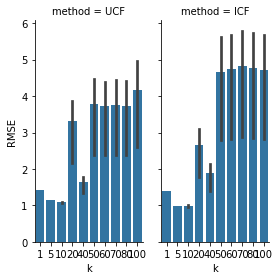

In [28]:
g = sns.FacetGrid(rmses, col="method", height=4, aspect=.5)
g.map(sns.barplot, "k", "RMSE")

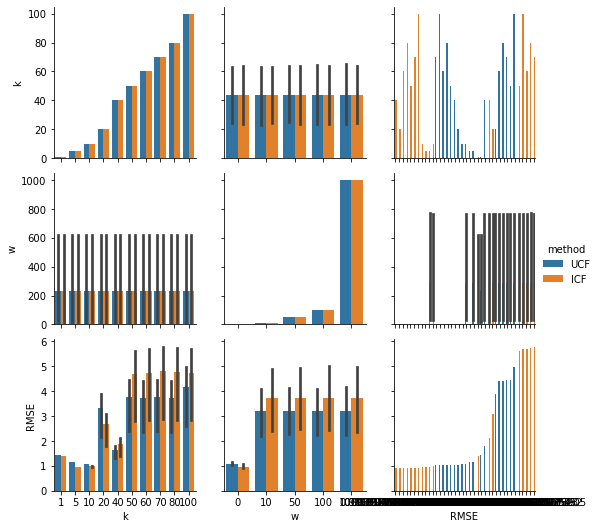

In [29]:
g = sns.PairGrid(rmses, hue="method")
g.map(sns.barplot)
g.add_legend()

We observe that RMSE increases as k and w increase. User based collaborative filtering gives in all circumstances better RMSE than Item based collaborative filtering irrelevant of w or k
